## Vlasov equations

We want to solve Vlasov equations on 1  (in $S^1$).

The equations are: 

\begin{align}
\partial_t f + p \partial_x f &= \frac{q}{m}E \partial_p f \\
\partial_t E = - J \\
\partial_x E = \rho \\
\end{align}

Where $f = f(t,x,p)$ is a distribution function in phase espace. 
Note that the invarian volume element is, 

$$
dP = dp_x/p_0
$$ 

We define, the particle number with respect to an observer with four-velocity $u^a$,

$$
N = \int f(x,p)(-u \cdot p)\; dP
$$ 

Thus, for the observer at rest in the coordinate system $(t,x)$ we get

$$
N = \int f(x,p) p_0 \; dP = \int f(x,p) \; dp_x
$$ 

Otherwise one has the four-vector particle density,

$$
N^a = \int f(x,p) p^a \; dP = \int f(x,p) \frac{p^a}{p_0} \; dp_x
$$

Thus, 

$$
N^x = \int f(x,p) \frac{p_x}{p_0} \; dp_x
$$

Likewise we have the energy-momentum tensor,

$$
T^{ab} = \int p^a p^b f(x,p) dP 
$$

So, 

$$
T^{00} = \int p^0 f(x,p) dp_x = m \int \sqrt{1 + p^2/m^2} dp
$$




\begin{align}
\rho(t,x) &:= q\int f(t,x,p) \; dp - n_0 \\
n_0 &:= q \int \int f(t,x,p) \; dp \; dx / V\\
J(t,x) &:= q \int v f(t,x,p) \; dp, \\
v &:= \frac{\frac{p}{m}}{\sqrt{1 + \frac{p^2}{m^2}}} \\ 
\end{align}

And $E = E(t,x)$ is the electric field.


The equilibrium distribution function is: 

$$
f(\gamma) = \frac{\gamma^2 \beta}{\theta K_2(\frac{1}{\theta})}\; e^{-\frac{\gamma}{\theta}} \;\;\;\; \gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$ 

or

$$
f(p) = \frac{1}{4\pi m^3 c^3 \theta K_2(\frac{1}{\theta})} \; e^{-\frac{\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2}
$$

and $K_2$ is the Bessel function of second kind.

In [39]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 1


In [53]:
plots = false #sacamos los plots
outputs = false #sacamos los outputs procesados

false

In [54]:
include("aux_functions_vlasov.jl")

counter_streams_rel_dist

In [55]:
run_name = "l_"


landau = false
two_streams = false
#landau = true
two_streams = true
#const Np = 201 # we take even since we need positive and negative values
#const Lx = 1
#const Lp = 0.5 # para cada lado

if landau
    if true #undamped
        const Lx = 39.738 
        const Nx = 3522
        const n = 2
        run_name = run_name * "landau_undamped"
    else #damped 
        const Lx = 7.455
        const Nx = 930
        const n = 15
        run_name = run_name * "landau_damped"
    end

    const Np = 200
    const Lp = 0.5
    
    α = 0.01
    k = 2*π*n/Lx
    θ = 0.001
    run_name = run_name * "$(Nx)_$(Np)_alp2_n$(n)_Th3"
elseif two_streams
    const Nx = 1000 # usar par para Fourier transform
    const Lx = 10.0
    const Np = 400
    const Lp = 1.0
    run_name = run_name * "two_streams_"
    const n = 1
    k = 2*π*n/Lx
    α = 0.1
    θ = 0.005
    vel = 0.2
    run_name = run_name * "$(Nx)_$(Np)_v_02_n4_o4_Th005"
end

dx = Lx/Nx # periodic boundary conditions
dp = 2*Lp/(Np-1) # Dichlet... or whatever but not periodic

const m = 1
const e =-1
#const q = 1

const κ = 2π/Lx

par_grid = (Nx, dx, Np, dp)

p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

run_name


"l_two_streams_1000_400_v_02_n4_o4_Th005"

In [56]:
#E = zeros(Nx)
#ϕ = zeros(Nx)
ρ = zeros(Nx) #charge density
S = zeros(Nx) #carge current
E_K = zeros(Nx) # kinetic energy
#E_E = zeros(Nx) # Electromagnetic energy
P = zeros(Nx) # Momentum
du = zeros(Nx * (Np+1)); # contains f and E


## Initial data

In [57]:
u = zeros(Nx * (Np+1))

pars = (Nx, dx, Lx, Np, dp, Lp, κ, e)



if landau
    pars_f = (m, θ, α, k)
    u = generate_initial_data!(landau_rel_dist, u, pars_f, pars);
elseif two_streams
    pars_f = (m, θ, vel, α, k)
    u = generate_initial_data!(counter_streams_rel_dist, u, pars_f, pars);
end

if plots

    F = reshape(u[1:Nx*Np],(Nx,Np));

    #plot(F[Nx÷2,:])
    plot_matrix(F)
    png("initial_dist_" * run_name)
end

n0 = -0.1442253930038297
n0 = -0.9999999999999999


In [58]:
if plots
    heatmap(F,
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function"
    )

    png("initial_conf_heat_" * run_name)
end

In [59]:
if plots 
    E_i = deepcopy(u[Nx*Np+1:end])
    get_current!(u, S, (Nx, dx, Np, dp, v, m, e));
    get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
    plot(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))

    x = [(i-1)*dx for i in 1:Nx]

    plot(layout=(2,2))
    plot!(subplot=1,x,ρ, title = "density", legend = :false)
    plot!(subplot=2,x,E_i, title = "Electric Field", legend = :false)
    plot!(subplot=3,x,S, title = "Current", legend = :false)
    plot!(subplot=4,x,E_K, title = "Kinetic Energy", legend = :false)

    png("initial_conf_" * run_name)
end

## Time evolution

In [60]:
t = 0.0
t_i = 0.0
t_f = 200.0
M = 20001
M_g = 500 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
par_evolv = (t_i, t_f, M, M_g, dt)



(0.0, 5.0, 501, 51, 0.01)

In [61]:
dvx = zeros(Nx)
dvp = zeros(Np)
k1 = zeros(Nx*(Np+1))
k2 = zeros(Nx*(Np+1))
k3 = zeros(Nx*(Np+1))
k4 = zeros(Nx*(Np+1))
p_F = (dx, dp, Nx, Np, v, S, dvx, dvp)
par_RK = (k1, k2, k3, k4)

if outputs
    # total quantities 
    Energy_K = zeros(M_g)
    Energy_E = zeros(M_g)
    EField_T = zeros(M_g)
    p_T = zeros(M_g)
    n_T = zeros(M_g)
    S_T = zeros(M_g)
    E_E = 0.0
    #T = zeros(M_g)
end

In [62]:
j = 1

if outputs
    Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
    Energy_E[j]  = get_E_energy(u,(Nx, dx))
    EField_T[j] = sum(u[Nx*Np+1:end])*dx
    p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx

    get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
    get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
    n_T[j] = get_total_density!(ρ,(Nx, dx))
    S_T[j] = sum(S)/n_T[j]/Nx
    #T[1] = var(u[N+1:2N])
end

In [63]:
run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)
if outputs
    run_data = Dict()
    run["Energy_E_$j"] = Energy_E[j]
    run["Energy_K_$j"] = Energy_K[j]
    run["E_f$j"] = u[Nx*Np+1:end]
    run["n_F$j"] = ρ
    run["S_F$j"] = S
    run["E_T$j"] = EField_T[j] 
    run["S_T$j"] = S_T[j]
    run["n_T$j"] = n_T[j]
end


file_name = "Results/"* run_name * ".jld2"
rm(file_name)
j = 1
tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end


401000-element Vector{Float64}:
 6.50965657697658e-22
 6.50964489560861e-22
 6.509609851965859e-22
 6.509551447431793e-22
 6.509469684312121e-22
 6.509364565834711e-22
 6.509236096149461e-22
 6.509084280328133e-22
 6.508909124364156e-22
 6.508710635172392e-22
 6.508488820588846e-22
 6.508243689370384e-22
 6.507975251194367e-22
 ⋮
 0.0011988554565200288
 0.0010991172143154024
 0.0009993355808451954
 0.0008995144953173953
 0.0007996578984969041
 0.000699769732552015
 0.000599853940896726
 0.000499914468035309
 0.00039995525940583754
 0.0002999802612273575
 0.00019999342034272144
 9.999868405934087e-5

### Temporal evolution: This takes a while!

In [47]:
#include("aux_functions_vlasov.jl")

for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_g-1)) == 0
        local j = (k-1)÷(M÷(M_g-1))+1
        if outputs
            Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
            Energy_E[j]  = get_E_energy(u,(Nx, dx))
            EField_T[j] = sum(u[Nx*Np+1:end])*dx
            p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx
            get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
            get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
            n_T[j] = get_total_density!(ρ,(Nx, dx))
            S_T[j] = sum(S)/n_T[j]/Nx
        end
        
        tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end
        Energy = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx + get_E_energy(u,(Nx, dx))
        println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $Energy")
        
    end
end

j = 2 , t = 0.09999999999999999, k = 11, nthreads = 1, Energy = 0.0
j = 3 , t = 0.20000000000000004, k = 21, nthreads = 1, Energy = 0.0
j = 4 , t = 0.3000000000000001, k = 31, nthreads = 1, Energy = 0.0
j = 5 , t = 0.4000000000000002, k = 41, nthreads = 1, Energy = 0.0
j = 6 , t = 0.5000000000000002, k = 51, nthreads = 1, Energy = 0.0
j = 7 , t = 0.6000000000000003, k = 61, nthreads = 1, Energy = 0.0
j = 8 , t = 0.7000000000000004, k = 71, nthreads = 1, Energy = 0.0
j = 9 , t = 0.8000000000000005, k = 81, nthreads = 1, Energy = 0.0
j = 10 , t = 0.9000000000000006, k = 91, nthreads = 1, Energy = 0.0
j = 11 , t = 1.0000000000000007, k = 101, nthreads = 1, Energy = 0.0
j = 12 , t = 1.1000000000000008, k = 111, nthreads = 1, Energy = 0.0
j = 13 , t = 1.2000000000000008, k = 121, nthreads = 1, Energy = 0.0
j = 14 , t = 1.300000000000001, k = 131, nthreads = 1, Energy = 0.0
j = 15 , t = 1.400000000000001, k = 141, nthreads = 1, Energy = 0.0
j = 16 , t = 1.500000000000001, k = 151, nthreads =

In [51]:
#file = jldopen(file_name, "r+")
#close(file)

JLDFile /home/oreula/Julia/Vlasov/Results/l_two_streams_1000_400_v_02_n4_o4_Th005.jld2 (read/write)
 ├─🔢 par_grid
 ├─🔢 run_name
 ├─🔢 p_Ini
 ├─🔢 par_evolv
 └─📂 u
    ├─🔢 u_00001
    ├─🔢 u_00002
    ├─🔢 u_00003
    ├─🔢 u_00004
    └─ ⋯ (47 more entries)

In [204]:
if outputs
    run = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[Nx*Np+1:end], "n_F" => ρ, "S_F" => S, "E_T"=> EField_T, "S_T" => S_T, "n_T" => n_T)
    save("Results/"* run_name * "th$(nthreads()).jld2", run)
end

### Shows the final data, warning lot of  memory for big grids! 

In [205]:
if plots
    F = reshape(u[1:Nx*Np],(Nx,Np));
    plot_matrix(F, camera=(90,70))
    #plot_matrix(F; fc=:heat)


    png("final_conf_" * run_name)
end

In [206]:
if plots 
    heatmap(F,
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function at t = $(t_f)"
    )

    png("final_conf_heat_" * run_name)
end

In [207]:
if plots
    ρ_f = zeros(Nx)
    E_f = zeros(Nx)
    ϕ_f = zeros(Nx)
    S_f = zeros(Nx)


    get_density!(u, ρ_f, (Nx, dx, Np, dp, m, e))
    n0 = get_total_density!(ρ_f, (Nx, dx))
    println("n0 = $(n0)")
    get_ϕ!(ϕ_f, ρ_f .- e*n0, κ)
    get_E_from_ϕ!(ϕ_f,E_f,dx)


    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,u[Nx*Np+1:end], label="E_final")

    png("Efield_th$(nthreads())_" * run_name)
end

n0 = -0.9999999998964644


In [208]:
if plots
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, n_T .+ 1.0, label="Total density")
    plot!(subplot=4, S_T, label="Total Current")

    png("final_totals_th$(nthreads())_" * run_name)
end

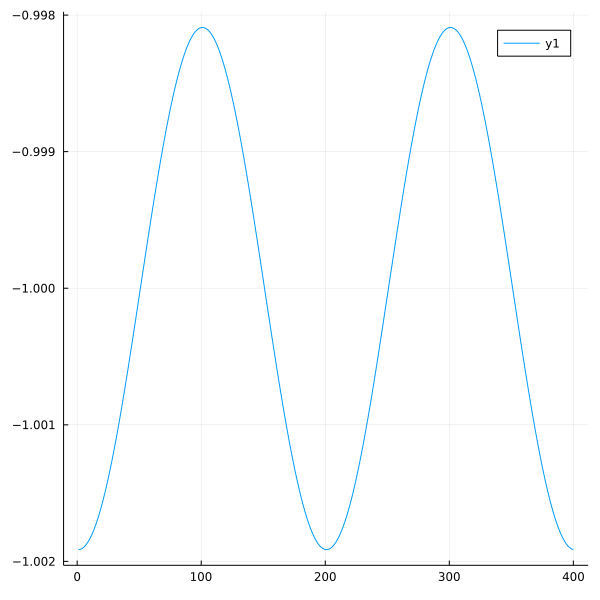

In [209]:
#plot(ρ_f)

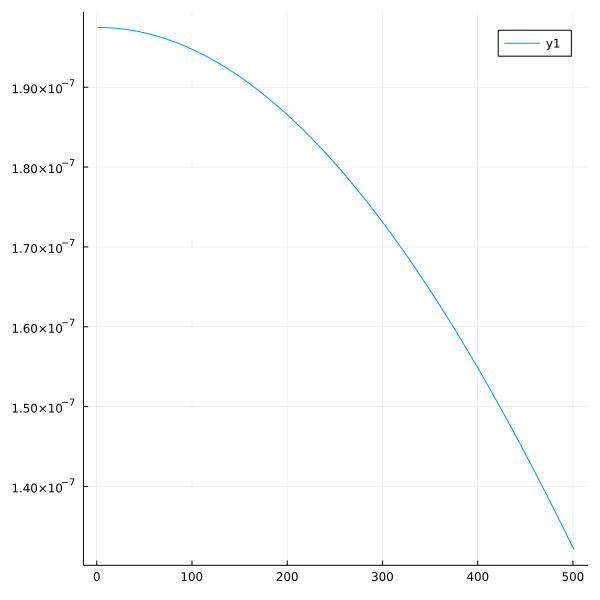

In [210]:
#plot(p_T)

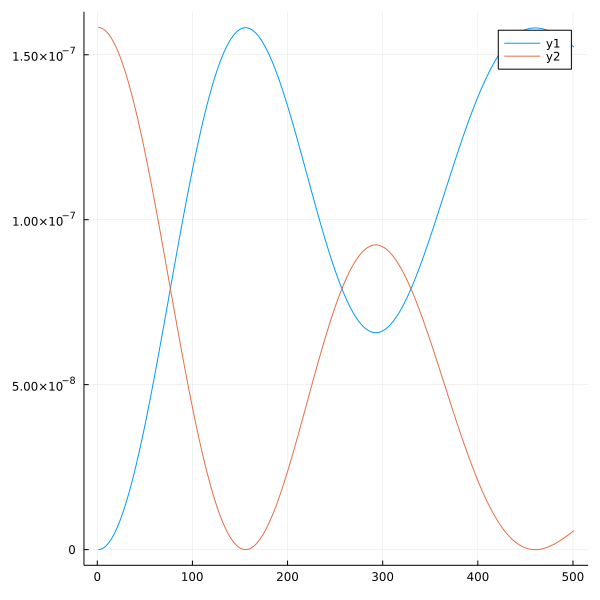

In [211]:
#Energy_K = load(run_name * "th$(nthreads())_results.jld2", "Energy_K")
#Energy_E = load(run_name * "th$(nthreads())_results.jld2", "Energy_E")
#plot(Energy_K .- Energy_K[1])
#plot!(Energy_E)


M = 501, M_g = 501


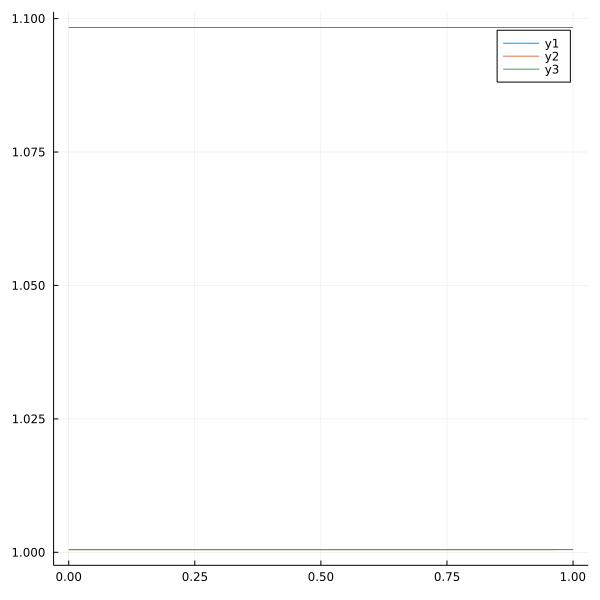

In [212]:
if plots
    println("M = $M, M_g = $M_g")
    tt = 0:dt*(M-1)/(M_g-1):t_f

    if true #undamped
        plot(tt,Energy_K)
        plot!(tt, 1.0005005 .+ 0.0000196*cos.(0.562*tt .- π/2).^2)
        plot!(tt, 1.0005103 .+ 0.0000196/2*cos.(0.562*2*tt .- π))
    else
        plot(tt,log10.(Energy_E))
        plot!(tt, log10.(10^(-7)*1.450*cos.(1.512*tt .- 0).^(2).*exp.(-0.03.* tt)))
    end
end

Los parámetros de fiteo son: 

### Caso undamped

    Lx = 39.738, Nx = 3522, Np = 200, Lp = 0.5

    α = 0.01
    n = 4
    k = 2*π*n/Lx
    θ = 0.001

$E_K = a + b*cos(\omega*t + \alpha)^2$ 

Tenemos $a = 1.0005005$, $b = 0.0000196$ $\omega = 0.562$, $\alpha = -\pi/2$

$E_K = a' + d'*cos(\omega' * t + \alpha')$ 

Tenemos $a'= 1.0005103$, $b'= 0.0000196/2$ $\omega' = 0.562*2$ $\alpha'= - π$

### Caso damped

    Lx = 7.455, Nx = 930, Np = 200, Lp = 0.5

    α = 0.01
    n = 15
    k = 2*π*n/Lx
    θ = 0.001

$E_E = b*cos(\omega*t)^2 e^{-\gamma * t}$ 

Tenemos: $b = 1.450 \; 10^{-7}$, $\omega = 1.512$, $\gamma = 0.03$


#### Note: 

Since we are using a $4\pi$ in the equation for E dot, we need to change E and t to get to the equations in the SHARP paper, for that we have to change time by a factor $\sqrt{4\pi}$. 

Using this factor we get:

#### undamped: #### 

$\omega = \; \sqrt{4π} * 0.562 \;= \;1.9922 $

#### damped: #### 

$\omega = \sqrt{4π} * 1.512 = 5.3599$, $\gamma = \sqrt{4π} * 0.03 = 0.1063$

In [213]:
#sqrt(4π)* 0.03

#5.36/4

1.34

In [214]:
#using LsqFit

In [215]:

#p0 = [0 ; 1; 0]
#@. model(x, p) = p[1]*sin(x*p[2])^2 * exp(-x*p[3]) #*cos(x*p[5] + p[6])

In [216]:
#t_series = [dt*(i-1)*(M-1)/(M_g-1) for i in 1:M_g];
#fit = curve_fit(model, t_series, Energy_E, p0);
#fit.param

ErrorException: syntax: invalid assignment location "$t_series" around /Users/reula/Julia/Vlasov/vlasov_1.ipynb:1

In [217]:
#20*sqrt(4π )

70.89815403622063